In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:

def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 2000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.3

In [2]:
df = pd.read_excel(r'C:\Users\Varun Kurup\Documents\testdatamodoldrnn.xlsx')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Label'])))

Shape of dataset  (1605, 2)
Index(['Text        ', 'Label'], dtype='object')
No. of unique classes 3


In [5]:
macronum=sorted(set(df['Label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['Label']=df['Label'].apply(fun)

In [6]:
texts = []
labels = []


for idx in range(df.iloc[:,0].shape[0]):
    text = BeautifulSoup(df.iloc[:,0][idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['Label']:
    labels.append(idx)

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 264


In [8]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (1605, 1000)
Shape of Label Tensor: (1605, 3)


In [9]:
embeddings_index = {}
f = open(r'C:\Users\Varun Kurup\Documents\glove.6B.100d.txt\glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [10]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [12]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])




print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         26500     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 187,903
Trainable params: 187,903
Non-trainable params: 0
_________________________________________________________________


In [13]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 1124 samples, validate on 481 samples
Epoch 1/15
1124/1124 [==============================] - 1886s 2s/step - loss: 0.5138 - acc: 0.7927 - val_loss: 0.2770 - val_acc: 0.9085

Epoch 00001: val_acc improved from -inf to 0.90852, saving model to model_rnn.hdf5
Epoch 2/15
1124/1124 [==============================] - 1346s 1s/step - loss: 0.1769 - acc: 0.9431 - val_loss: 0.1724 - val_acc: 0.9501

Epoch 00002: val_acc improved from 0.90852 to 0.95010, saving model to model_rnn.hdf5
Epoch 3/15
1124/1124 [==============================] - 1489s 1s/step - loss: 0.1183 - acc: 0.9644 - val_loss: 0.1591 - val_acc: 0.9501

Epoch 00003: val_acc did not improve from 0.95010
Epoch 4/15
1124/1124 [==============================] - 861s 766ms/step - loss: 0.0757 - acc: 0.9760 - val_loss: 0.1710 - val_acc: 0.9522

Epoch 00004: val_acc improved from 0.95010 to 0.95218, saving model to model_rnn.hdf5
Epoch 5/15
1124/1124 [==============================] - 9254s 8s/step - loss: 0.0613 - acc: 0.9840

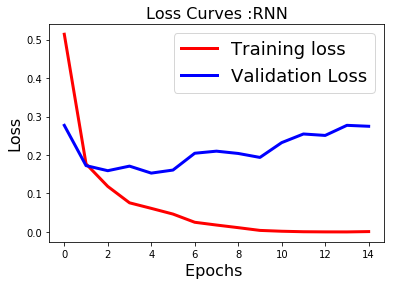

In [14]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

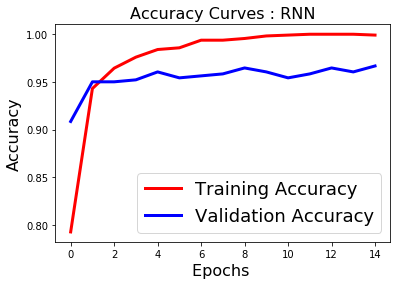

In [15]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

In [1]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='cross_val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

NameError: name 'ModelCheckpoint' is not defined

In [4]:
df.describe()

,Label
count,1605.000000
mean,0.963863
std,0.965071
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000
